# Imports

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from enviroment import Environment
from memory import Memory
from dqn import DQN
import sys
from collections import deque

# First we will test the Environment

In [191]:
NUM_USERS = 4
NUM_CHANNELS = 3
ATTEMPT_PROB = 1

In [192]:
#initializing the environment
envTest = Environment(NUM_USERS,NUM_CHANNELS,ATTEMPT_PROB)


In [201]:
# To sample random  actions from action_space
action = envTest.sample()
print(action)

[2 1 0 0]


In [202]:
obs = envTest.step(action)
print(obs)

[(1, 1.0), (1, 1.0), (0, 0.0), (0, 0.0), array([0, 0, 1])]


Get reward array

In [ ]:
def getRewardFromObservation(observation, numUsers):
    return [i[1] for i in observation[:numUsers]]

In [ ]:
# to take reward from obs
print(getRewardFromObservation(obs, NUM_USERS))

## Helper Functions

In [ ]:
#generates next-state from action and observation
def state_generator(action,obs, NUM_CHANNELS):
    input_vector = []
    if action is None:
        print ('None')
        sys.exit()
    for user_i in range(action.size):
        input_vector_i = one_hot(action[user_i],NUM_CHANNELS+1)
        channel_alloc = obs[-1]
        input_vector_i = np.append(input_vector_i,channel_alloc)
        input_vector_i = np.append(input_vector_i,int(obs[user_i][0]))
        input_vector.append(input_vector_i)
    return input_vector

In [ ]:
def get_states(batch): 
    states = []
    for  i in batch:
        states_per_batch = []
        for step_i in i:
            states_per_step = []
            for user_i in step_i[0]:
                states_per_step.append(user_i)
            states_per_batch.append(states_per_step)
        states.append(states_per_batch)     
   
    return states


In [ ]:
def get_actions(batch):
    actions = []
    for each in batch:
        actions_per_batch = []
        for step_i in each:
            actions_per_step = []
            for user_i in step_i[1]:
                actions_per_step.append(user_i)
            actions_per_batch.append(actions_per_step)
        actions.append(actions_per_batch)

    return actions

In [ ]:
def get_rewards(batch):
    rewards = []
    for each in batch:
        rewards_per_batch = []
        for step_i in each:
            rewards_per_step = []
            for user_i in step_i[2]:
                rewards_per_step.append(user_i)
            rewards_per_batch.append(rewards_per_step)
        rewards.append(rewards_per_batch)
    return rewards

In [ ]:
def get_next_states(batch):
    next_states = []
    for each in batch:
        next_states_per_batch = []
        for step_i in each:
            next_states_per_step = []
            for user_i in step_i[3]:
                next_states_per_step.append(user_i)
            next_states_per_batch.append(next_states_per_step)
        next_states.append(next_states_per_batch)
    return next_states 

In [ ]:
def get_states_user(batch, NUM_USERS):
    states = []
    for user in range(NUM_USERS):
        states_per_user = []
        for each in batch:
            states_per_batch = []
            for step_i in each:
                
                try:
                    states_per_step = step_i[0][user]
                    
                except IndexError:
                    print (step_i)
                    print ("-----------")
                    
                    print ("eror")
                    sys.exit()
                states_per_batch.append(states_per_step)
            states_per_user.append(states_per_batch)
        states.append(states_per_user)
    return np.array(states)

In [ ]:
def get_actions_user(batch, NUM_USERS):
    actions = []
    for user in range(NUM_USERS):
        actions_per_user = []
        for each in batch:
            actions_per_batch = []
            for step_i in each:
                actions_per_step = step_i[1][user]
                actions_per_batch.append(actions_per_step)
            actions_per_user.append(actions_per_batch)
        actions.append(actions_per_user)
    return np.array(actions)

In [ ]:
def get_rewards_user(batch, NUM_USERS):
    rewards = []
    for user in range(NUM_USERS):
        rewards_per_user = []
        for each in batch:
            rewards_per_batch = []
            for step_i in each:
                rewards_per_step = step_i[2][user] 
                rewards_per_batch.append(rewards_per_step)
            rewards_per_user.append(rewards_per_batch)
        rewards.append(rewards_per_user)
    return np.array(rewards)

In [ ]:
def get_next_states_user(batch, NUM_USERS):
    next_states = []
    for user in range(NUM_USERS):
        next_states_per_user = []
        for each in batch:
            next_states_per_batch = []
            for step_i in each:
                next_states_per_step = step_i[3][user] 
                next_states_per_batch.append(next_states_per_step)
            next_states_per_user.append(next_states_per_batch)
        next_states.append(next_states_per_user)
    return np.array(next_states)

In [ ]:
def one_hot(num,len):
    assert num >=0 and num < len ,"error"
    vec = np.zeros([len],np.int32)
    vec[num] = 1
    return vec

# Train Network

Define Hyperparameters

In [ ]:
memory_size = 1000                      
batch_size = 128                         
pretrain_length = batch_size            
hidden_size = 128                       
learning_rate = 0.0001                  
explore_start = .02                     
explore_stop = 0.01                     
decay_rate = 0.0001                     
gamma = 0.9                             
step_size=1                            
alpha=0                                 
epsilon = explore_start
beta = 1                               


Populate Memory

In [ ]:

def populateMemory(environment, memory, step_size, pretrain_length=128):
    historyInput = deque(maxlen=step_size)
    action = environment.sample()
    obs = environment.step(action)  
    state = state_generator(action,obs, environment.numChannels)
    reward = getRewardFromObservation(obs, environment.numUsers)

    for ii in range(pretrain_length*step_size*5):    
        action = environment.sample()
        obs = environment.step(action)  
        next_state = state_generator(action,obs, environment.numChannels)
        reward = getRewardFromObservation(obs, environment.numUsers)
        memory.add((state,action,reward,next_state))
        state = next_state
        historyInput.append(state)

    return historyInput

In [ ]:
def trainDQNetwork(episodes, epochs, qNetwork, environment, memory, historyInput, gamma, explore_stop, decay_rate, epsilon, step_size, beta):
    
    cumulativeReward = [0]
    cumulativeCollision = [0]
    totalRewards = list()
    for episode in range(episodes):

        if episode %50 == 0:
            if episode < 1000:
                beta -=0.001


        print("Episode " + str(episode))
        # decide whether to explore or not
        action = environment.sample()
        obs = environment.step(action)
        state = state_generator(action, obs, environment.numChannels)

        if np.random.random() < epsilon:
            action = environment.sample()
        else:
            action = np.zeros([environment.numUsers], dtype=np.int32)

            stateVector = np.array(historyInput)
            # print(stateVector)
            for u in range(environment.numUsers):
                userState = stateVector[:, u, :].reshape(1, step_size, state_size)
                prediction = qNetwork.predict(userState)

                prob1 = (1-alpha)*np.exp(beta*prediction)

                # Normalizing probabilities of each action  with temperature (beta) 
                prob = prob1/np.sum(np.exp(beta*prediction)) + alpha/(environment.numChannels+1)
                

                #  choosing action with max probability
                action[u] = np.argmax(prob,axis=1)
   
        
        action = action.astype(np.int32)
        # print(action)
        obs = environment.step(action)
        nextState = state_generator(action, obs, environment.numChannels)

        reward = getRewardFromObservation(obs, environment.numUsers)
        sum_r =  np.sum(reward)

        totalRewards.append(sum_r/environment.numChannels)

        for i in range(len(reward)):
            if reward[i] > 0:
                reward[i] = sum_r

        # print(reward)
        memory.add((state, action, reward, nextState))
        state = nextState
        historyInput.append(state)

        batch = memory.sample(batch_size, step_size)

        states = get_states_user(batch, environment.numUsers)
        actions = get_actions_user(batch, environment.numUsers)
        rewards = get_rewards_user(batch, environment.numUsers)
        nextStates = get_next_states_user(batch, environment.numUsers)

        states = np.reshape(states,[-1,states.shape[2],states.shape[3]])
        actions = np.reshape(actions,[-1,actions.shape[2]])
        rewards = np.reshape(rewards,[-1,rewards.shape[2]])
        nextStates = np.reshape(nextStates,[-1,nextStates.shape[2],nextStates.shape[3]])

        # print(nextStates.shape)
        targetQ = qNetwork.predict(nextStates)
        targets = rewards[:,-1] + gamma * np.max(targetQ, axis=1)
        qNetwork.train(states, epochs, targets, batch_size)

        epsilon = max(explore_stop, epsilon * decay_rate)

    return totalRewards


# Simulations

Simulation 1 (2 channels 3 users) [10]

In [ ]:
numUsers = 3
numChannels = 2
probability = 0.8
state_size = 2 *(numChannels + 1)      
action_size = numChannels + 1
episodes = 5000


environment = Environment(numUsers, numChannels)
memory = Memory(memory_size)
historyInput = populateMemory(environment, memory, step_size)

qNetwork = DQN(learning_rate, state_size, action_size, [10], step_size, "TestNet")
simulation1 = trainDQNetwork(episodes, 50, qNetwork, environment, memory, historyInput, gamma, explore_stop, decay_rate, epsilon, step_size, beta)

Simulation 2 (3 channels 4 users) [10]

In [ ]:
numUsers = 4
numChannels = 3
probability = 0.8
state_size = 2 *(numChannels + 1)      
action_size = numChannels + 1
episodes = 5000


environment = Environment(numUsers, numChannels)
memory = Memory(memory_size)
historyInput = populateMemory(environment, memory, step_size)

qNetwork = DQN(learning_rate, state_size, action_size, [10], step_size, "TestNet")
simulation2 = trainDQNetwork(episodes, 50, qNetwork, environment, memory, historyInput, gamma, explore_stop, decay_rate, epsilon, step_size, beta)

Simulation 3 (4 channels 5 users) [128 64]

In [ ]:
numUsers = 4
numChannels = 5
probability = 0.8
state_size = 2 *(numChannels + 1)      
action_size = numChannels + 1
episodes = 5000


environment = Environment(numUsers, numChannels)
memory = Memory(memory_size)
historyInput = populateMemory(environment, memory, step_size)

qNetwork = DQN(learning_rate, state_size, action_size, [128, 64], step_size, "simulation_3")
simulation3 = trainDQNetwork(episodes, 50, qNetwork, environment, memory, historyInput, gamma, explore_stop, decay_rate, epsilon, step_size, beta)

Simulation 4 (2 channels 3 users) [64 64]

In [ ]:
numUsers = 3
numChannels = 2
probability = 0.8
state_size = 2 *(numChannels + 1)
action_size = numChannels + 1
episodes = 5000


environment = Environment(numUsers, numChannels)
memory = Memory(memory_size)
historyInput = populateMemory(environment, memory, step_size)

qNetwork = DQN(learning_rate, state_size, action_size, [64, 64], step_size, "Simulation_4")
simulation4 = trainDQNetwork(episodes, 50, qNetwork, environment, memory, historyInput, gamma, explore_stop, decay_rate, epsilon, step_size, beta)

Simulation 5 (2 channels 3 users) [64 128 64]

In [ ]:
numUsers = 3
numChannels = 2
probability = 0.8
state_size = 2 *(numChannels + 1)
action_size = numChannels + 1
episodes = 5000


environment = Environment(numUsers, numChannels)
memory = Memory(memory_size)
historyInput = populateMemory(environment, memory, step_size)

qNetwork = DQN(learning_rate, state_size, action_size, [64, 128, 64], step_size, "Simulation_5")

Simulation 6 (3 channels 4 users) [64 64]

In [ ]:
numUsers = 4
numChannels = 3
probability = 0.8
state_size = 2 *(numChannels + 1)
action_size = numChannels + 1
episodes = 5000


environment = Environment(numUsers, numChannels)
memory = Memory(memory_size)
historyInput = populateMemory(environment, memory, step_size)

qNetwork = DQN(learning_rate, state_size, action_size, [64, 64], step_size, "simulation_6")
simulation6 = trainDQNetwork(episodes, 50, qNetwork, environment, memory, historyInput, gamma, explore_stop, decay_rate, epsilon, step_size, beta)

# Results

In [ ]:
def writeListToFile(filePath, inputList):
    with open(filePath, 'w') as file:
        for item in inputList:
            file.write(str(item) + '\n')

In [ ]:
def readListFromFile(filePath):
    resultList = []
    with open(filePath, 'r') as file:
        for line in file:
            item = line.strip()
            resultList.append(float(item))

    return resultList


In [63]:
def averageElements(inputList, n):

    resultList = []
    for i in range(0, len(inputList), n):
        chunk = inputList[i:i+n]
        average = sum(chunk) / len(chunk)
        resultList.append(average)

    return resultList

In [79]:
def cumulativeElements(inputList):
    resultList = [0]
    for i in range(0, len(inputList)):
        
        resultList.append(resultList[-1] + inputList[i])

    return resultList

In [112]:
# there is an error in the training loop, I meant to divide 
# by the number of channels instead of the number of users

simulation1Results = readListFromFile("simulation_1.txt")
simulation2Results = readListFromFile("simulation_2.txt")
simulation3Results = readListFromFile("simulation_3.txt")
simulation4Results = readListFromFile("simulation_4.txt")
simulation5Results = readListFromFile("simulation_5.txt")
simulation6Results = readListFromFile("simulation_6.txt")

# divide by channels and multiply by users to get correct
simulation1Results = [i*3/2 for i in simulation1Results]
simulation2Results = [i*4/3 for i in simulation2Results]
simulation3Results = [i*5/4 for i in simulation3Results]
simulation4Results = [i*2/3 for i in simulation4Results]
simulation5Results = [i*3/2 for i in simulation5Results]
simulation6Results = [i*4/3 for i in simulation5Results]

#get just sum of reward
simulation1Rewards = [i*3 for i in simulation1Results]
simulation2Rewards = [i*4 for i in simulation2Results]
simulation3Rewards = [i*5 for i in simulation3Results]
simulation4Rewards = [i*2 for i in simulation4Results]
simulation5Rewards = [i*3 for i in simulation5Results]
simulation6Rewards = [i*4 for i in simulation5Results]

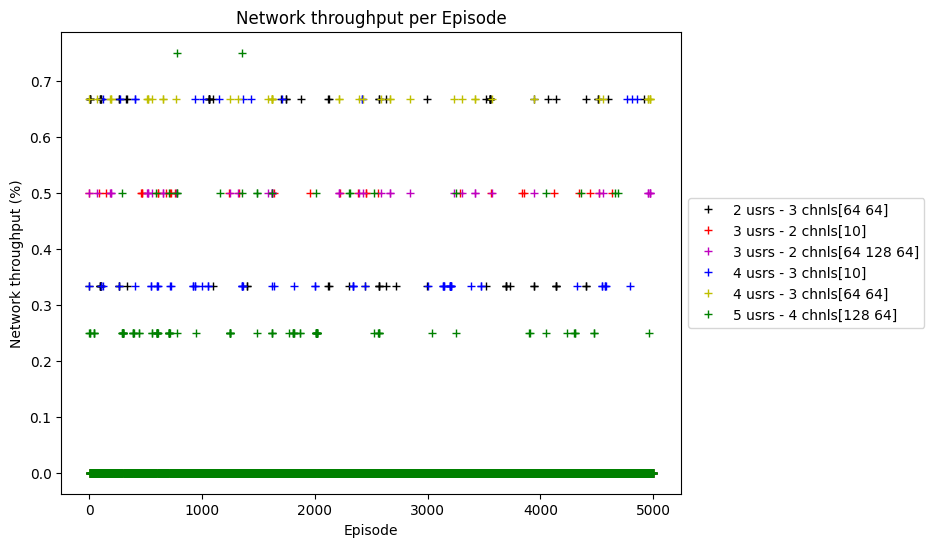

In [215]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.plot(range(len(simulation4Results)), simulation4Results, 'k+',label="2 usrs - 3 chnls[64 64]")
plt.plot(range(len(simulation1Results)), simulation1Results, 'r+',label="3 usrs - 2 chnls[10]")
plt.plot(range(len(simulation5Results)), simulation5Results, 'm+',label="3 usrs - 2 chnls[64 128 64]")
plt.plot(range(len(simulation2Results)), simulation2Results, 'b+',label="4 usrs - 3 chnls[10]")
plt.plot(range(len(simulation6Results)), simulation6Results, 'y+',label="4 usrs - 3 chnls[64 64]")
plt.plot(range(len(simulation3Results)), simulation3Results, 'g+',label="5 usrs - 4 chnls[128 64]")
# plt.legend()
plt.title("Network throughput per Episode")
plt.xlabel("Episode")
plt.ylabel("Network throughput (%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("throughput.png", bbox_inches='tight')


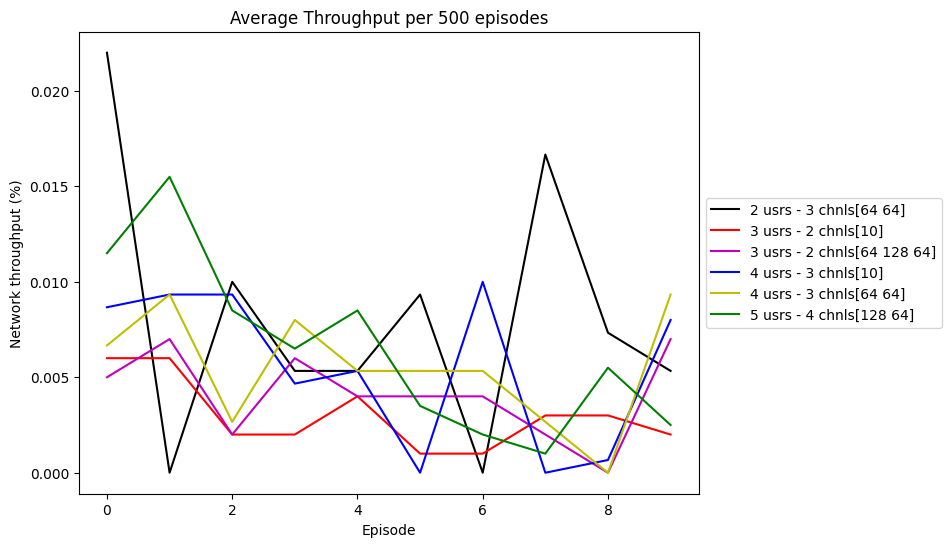

In [216]:
simulation1Average = averageElements(simulation1Results, 500)
simulation2Average = averageElements(simulation2Results, 500)
simulation3Average = averageElements(simulation3Results, 500)
simulation4Average = averageElements(simulation4Results, 500)
simulation5Average = averageElements(simulation5Results, 500)
simulation6Average = averageElements(simulation6Results, 500)

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.plot(np.arange(len(simulation4Average)), simulation4Average, 'k', label="2 usrs - 3 chnls[64 64]")
plt.plot(np.arange(len(simulation1Average)), simulation1Average, 'r', label="3 usrs - 2 chnls[10]")
plt.plot(np.arange(len(simulation5Average)), simulation5Average, 'm', label="3 usrs - 2 chnls[64 128 64]")
plt.plot(np.arange(len(simulation2Average)), simulation2Average, 'b', label="4 usrs - 3 chnls[10]")
plt.plot(np.arange(len(simulation6Average)), simulation6Average, 'y', label="4 usrs - 3 chnls[64 64]")
plt.plot(np.arange(len(simulation3Average)), simulation3Average, 'g', label="5 usrs - 4 chnls[128 64]")
plt.title("Average Throughput per 500 episodes")
plt.xlabel("Episode")
plt.ylabel("Network throughput (%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("throughput_avg.png", bbox_inches='tight')

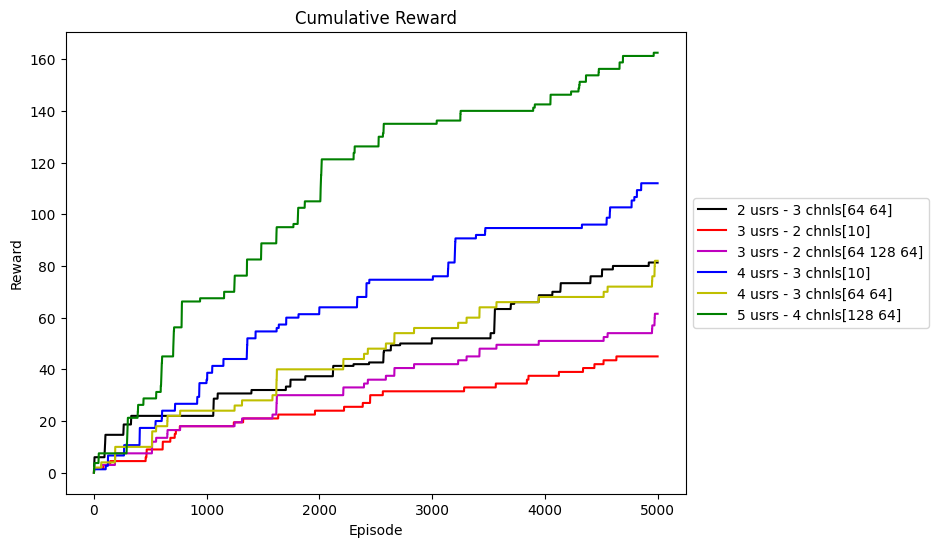

In [217]:
simulation1Cumulative = cumulativeElements(simulation1Rewards)
simulation2Cumulative = cumulativeElements(simulation2Rewards)
simulation3Cumulative = cumulativeElements(simulation3Rewards)
simulation4Cumulative = cumulativeElements(simulation4Rewards)
simulation5Cumulative = cumulativeElements(simulation5Rewards)
simulation6Cumulative = cumulativeElements(simulation6Rewards)

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.plot(np.arange(len(simulation4Cumulative)), simulation4Cumulative, 'k', label="2 usrs - 3 chnls[64 64]")
plt.plot(np.arange(len(simulation1Cumulative)), simulation1Cumulative, 'r', label="3 usrs - 2 chnls[10]")
plt.plot(np.arange(len(simulation5Cumulative)), simulation5Cumulative, 'm', label="3 usrs - 2 chnls[64 128 64]")
plt.plot(np.arange(len(simulation2Cumulative)), simulation2Cumulative, 'b', label="4 usrs - 3 chnls[10]")
plt.plot(np.arange(len(simulation6Cumulative)), simulation6Cumulative, 'y', label="4 usrs - 3 chnls[64 64]")
plt.plot(np.arange(len(simulation3Cumulative)), simulation3Cumulative, 'g', label="5 usrs - 4 chnls[128 64]")
plt.title("Cumulative Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("cumreward.png", bbox_inches='tight')

Create Histograms for each type of simulation

In [218]:
#plot histogram for each simulation
from collections import Counter

def getValuesAndCount(inputList):
    counts = Counter(inputList)
    return np.array(list(counts.values())), np.array(list(counts.keys()))


simulation1Counts, simulation1Values = getValuesAndCount(simulation1Results)
simulation2Counts, simulation2Values = getValuesAndCount(simulation2Results)
simulation3Counts, simulation3Values = getValuesAndCount(simulation3Results)
simulation4Counts, simulation4Values = getValuesAndCount(simulation4Results)
simulation5Counts, simulation5Values = getValuesAndCount(simulation5Results)
simulation6Counts, simulation6Values = getValuesAndCount(simulation6Results)


print(simulation1Values)



[0.5 0. ]


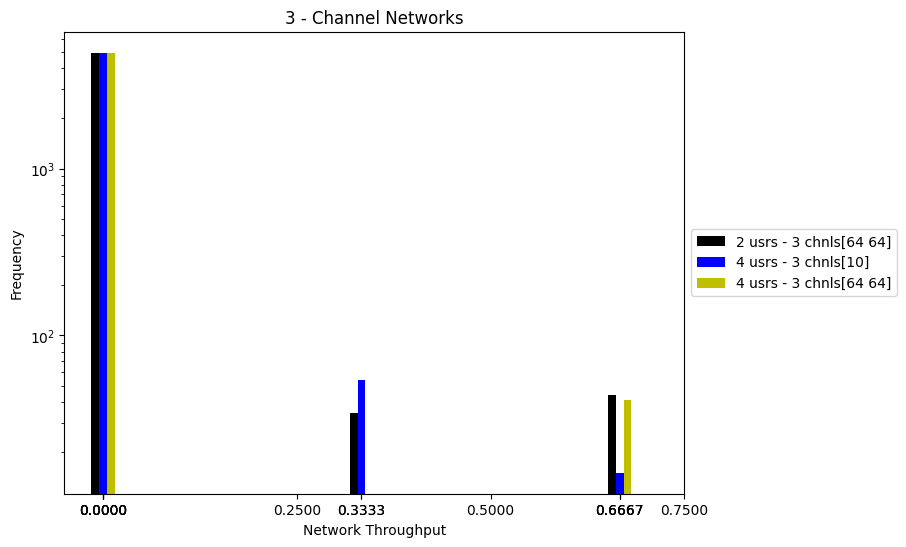

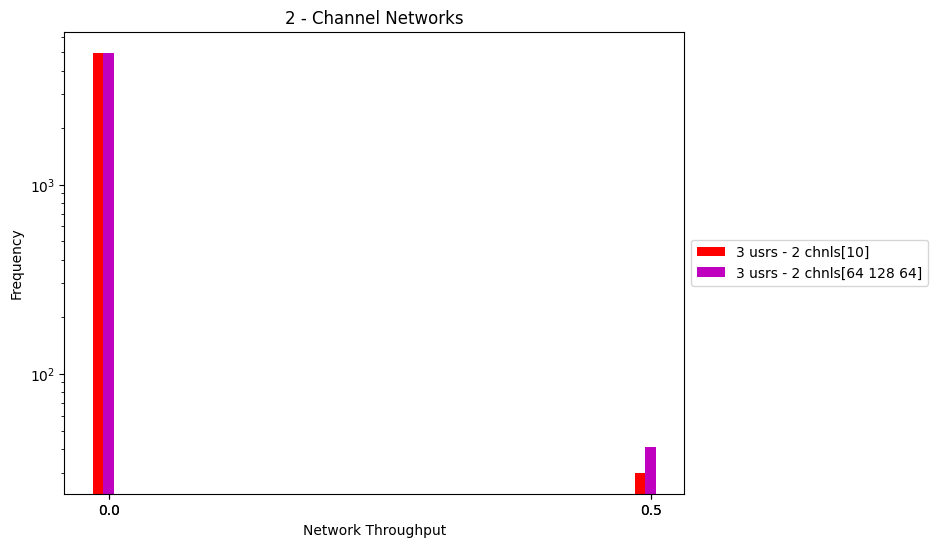

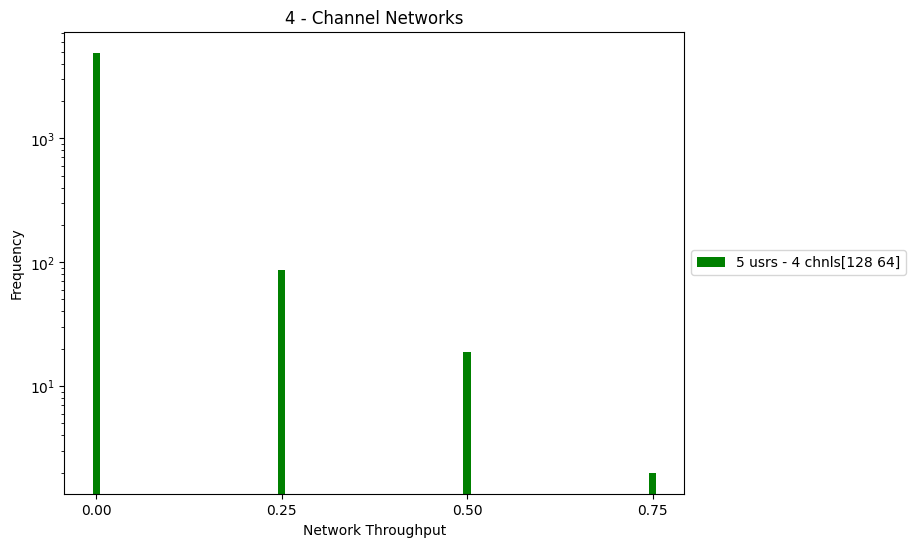

In [219]:
w1 = 0.01
w2 = 0.01

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.bar(simulation4Values-w, simulation4Counts, width=w, color='k', label="2 usrs - 3 chnls[64 64]")
plt.bar(simulation2Values, simulation2Counts, width=w, color='b', label="4 usrs - 3 chnls[10]")
plt.bar(simulation6Values+w, simulation6Counts, width=w, color='y', label="4 usrs - 3 chnls[64 64]")
plt.yscale('log')
plt.xticks(np.concatenate([simulation2Values, simulation3Values, simulation4Values, simulation6Values]))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Frequency")
plt.xlabel("Network Throughput")
plt.title("3 - Channel Networks")
plt.show()
fig.savefig("hist3chnls.png", bbox_inches='tight')

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.bar(simulation1Values-w, simulation1Counts, width=w, color='r', label="3 usrs - 2 chnls[10]")
plt.bar(simulation5Values, simulation5Counts, width=w, color='m', label="3 usrs - 2 chnls[64 128 64]")
plt.xticks(np.concatenate([simulation5Values, simulation1Values]))
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Network Throughput")
plt.title("2 - Channel Networks")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("hist2chnls.png", bbox_inches='tight')

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.bar(simulation3Values, simulation3Counts, width=w, color='g', label="5 usrs - 4 chnls[128 64]")
plt.xticks(simulation3Values)
plt.yscale('log')
plt.ylabel("Frequency")
plt.xlabel("Network Throughput")
plt.title("4 - Channel Networks")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("hist4chnls.png", bbox_inches='tight')
plt.show()